# 140k Real and Fake Faces

We do Brain Real and Fake Faces using 3 different base models with transfer learning and with an ensemble of the models:
* ResNet v2
* VGG16
* Xception

Finally, we will display the activation maps using Grad-Cam.

Enjoy the notebook and feedback greatly appreciated.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You should use mixed precision if you use TPUs or NVIDIA GPUs with at least compute capability 7.0, as it will improve performance by up to 3x.
# With this policy, layers use float16 computations and float32 variables. Computations are done in float16 for performance, but variables must be kept in float32 for numeric stability.
# IMPORTANT : A softmax activation at the end of the model should be float32.
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Overall Settings

In [2]:
FINE_TUNING_EPOCHS = 7
TRAINING_EPOCHS = 3
BATCH_SIZE = 512

image_height = 256
image_width = 256

# Load data

In [3]:
train_df = pd.read_csv("/kaggle/input/140k-real-and-fake-faces/train.csv")
valid_df = pd.read_csv("/kaggle/input/140k-real-and-fake-faces/valid.csv")
test_df  = pd.read_csv("/kaggle/input/140k-real-and-fake-faces/test.csv")

In [4]:
train_df

,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg
...,...,...,...,...,...,...
99995,49995,/kaggle/input/1-million-fake-faces/1m_faces_04...,H1JLRZ3J8U,0,fake,train/fake/H1JLRZ3J8U.jpg
99996,49996,/kaggle/input/1-million-fake-faces/1m_faces_00...,NRHSNJCH6X,0,fake,train/fake/NRHSNJCH6X.jpg
99997,49997,/kaggle/input/1-million-fake-faces/1m_faces_00...,2KN0ZS1R7V,0,fake,train/fake/2KN0ZS1R7V.jpg
99998,49998,/kaggle/input/1-million-fake-faces/1m_faces_04...,Y6UL82SD8A,0,fake,train/fake/Y6UL82SD8A.jpg


In [5]:
valid_df

,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg
...,...,...,...,...,...,...
19995,9995,/kaggle/input/1-million-fake-faces/1m_faces_00...,HEK1JMB42D,0,fake,valid/fake/HEK1JMB42D.jpg
19996,9996,/kaggle/input/1-million-fake-faces/1m_faces_04...,YRK2K51TET,0,fake,valid/fake/YRK2K51TET.jpg
19997,9997,/kaggle/input/1-million-fake-faces/1m_faces_12...,5KB4VZJE9Z,0,fake,valid/fake/5KB4VZJE9Z.jpg
19998,9998,/kaggle/input/1-million-fake-faces/1m_faces_00...,PL40A1KEVB,0,fake,valid/fake/PL40A1KEVB.jpg


In [6]:
test_df = test_df.sample(frac=1)

In [7]:
test_df

,Unnamed: 0,original_path,id,label,label_str,path
311,311,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,63897,1,real,test/real/63897.jpg
19758,9758,/kaggle/input/1-million-fake-faces/1m_faces_00...,7BOLWXXOC2,0,fake,test/fake/7BOLWXXOC2.jpg
6789,6789,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,69648,1,real,test/real/69648.jpg
6853,6853,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,13683,1,real,test/real/13683.jpg
8897,8897,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,34249,1,real,test/real/34249.jpg
...,...,...,...,...,...,...
3724,3724,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,09591,1,real,test/real/09591.jpg
6081,6081,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,37635,1,real,test/real/37635.jpg
7664,7664,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,09901,1,real,test/real/09901.jpg
11477,1477,/kaggle/input/1-million-fake-faces/1m_faces_12...,009ZTJ3621,0,fake,test/fake/009ZTJ3621.jpg


# Data Generators

In [8]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [9]:
main_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

In [10]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         #horizontal_flip = True,
                         #vertical_flip   = True,
                         #zoom_range      = 0.05,
                         #rotation_range  = 25
                        )
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory   = main_dir, # images data path / folder in which images are there
    x_col       = 'path',
    y_col       = 'label_str',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 100000 validated image filenames belonging to 2 classes.


In [11]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_dir, # images data path / folder in which images are there
    x_col       = 'path',
    y_col       = 'label_str',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_dir, # images data path / folder in which images are there
    x_col       = 'path',
    y_col       = 'label_str',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False)

Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [12]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [13]:
class_names

['fake', 'real']

In [14]:
train_freq      = np.unique(train_generator.classes, return_counts=True)
validation_freq = np.unique(validation_generator.classes, return_counts=True)
test_freq       = np.unique(test_generator.classes, return_counts=True)

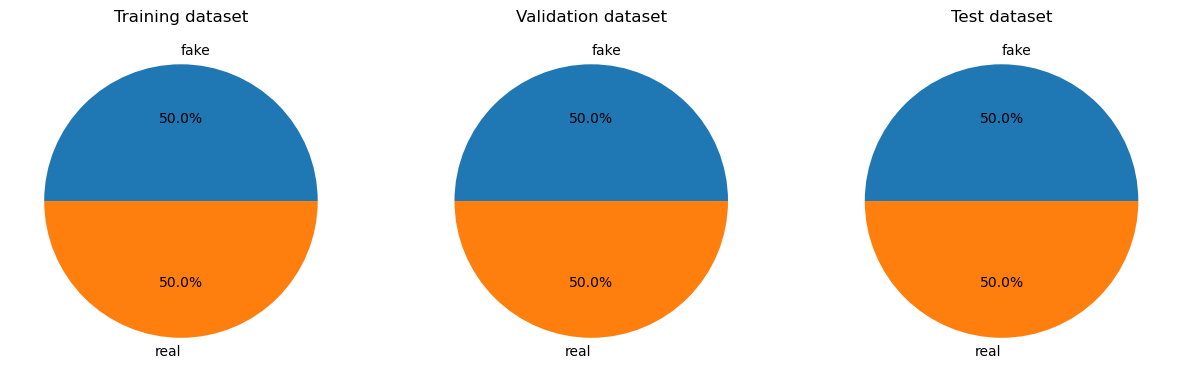

In [15]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].set_title("Training dataset")
ax[0].pie(train_freq[1], labels = class_names, autopct='%1.1f%%');
ax[1].set_title("Validation dataset")
ax[1].pie(validation_freq[1], labels = class_names, autopct='%1.1f%%');
ax[2].set_title("Test dataset")
ax[2].pie(test_freq[1], labels = class_names, autopct='%1.1f%%');

In [16]:
# clearly an umbalanced data set so let's some class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

In [17]:
class_weights

{0: 1.0, 1: 1.0}

In [18]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])    

# Sample Images

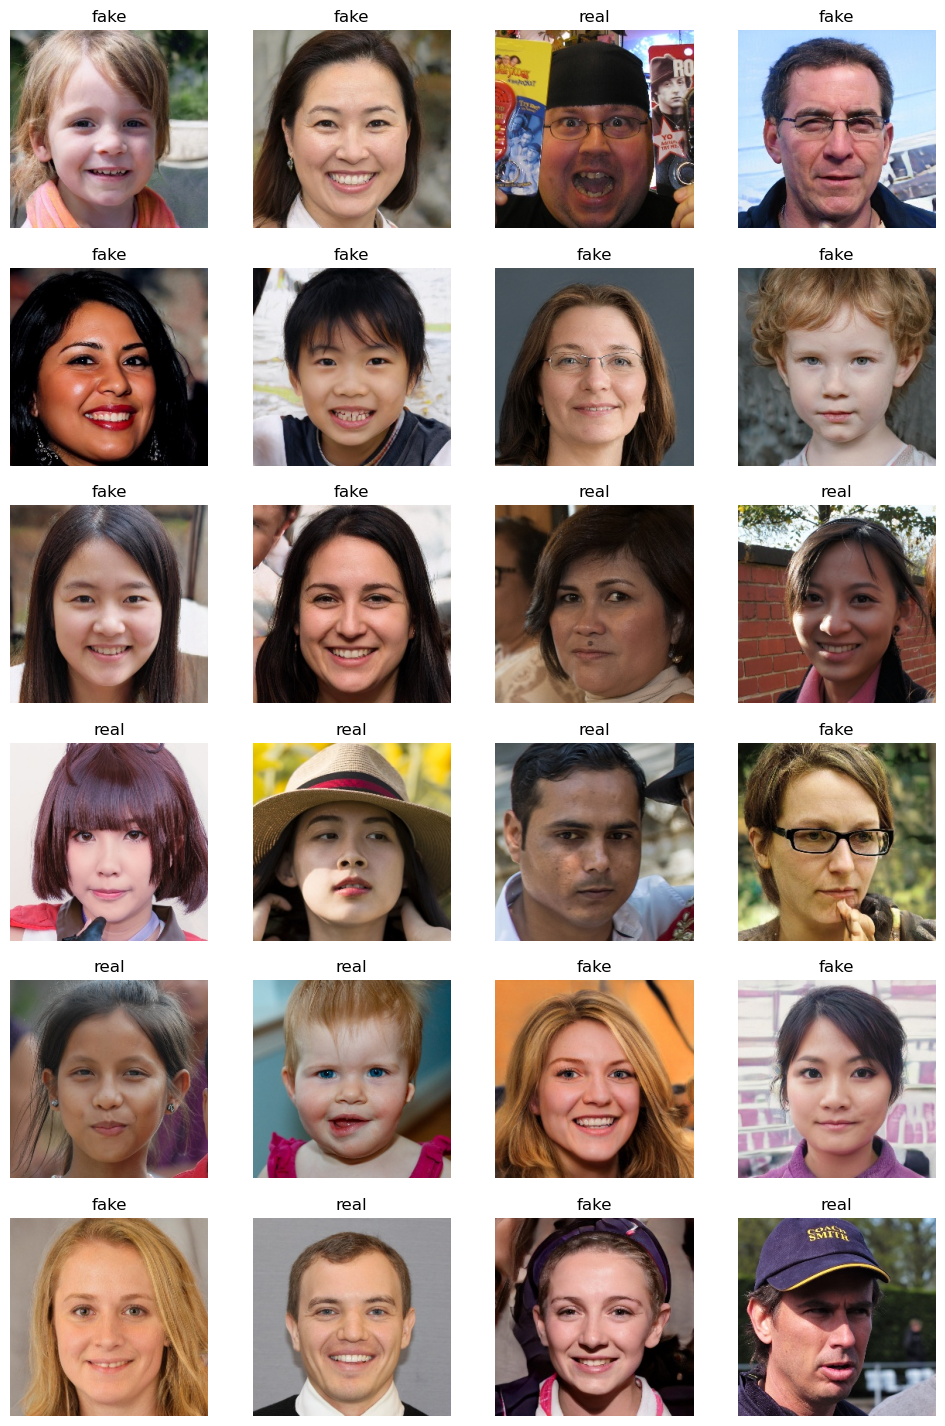

In [19]:
x,y = next(train_generator)
plot_images(x,y)

In [20]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [21]:

from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'
    
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    
    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

# Grad-Cam

In [22]:
from matplotlib import cm

def make_gradcam_heatmap(image, model, last_conv_layer_name):
 
    img_array = tf.expand_dims(image, axis=0)
    
    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    
    
     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation
    
    return superimposed_img

# Model

In [23]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax', dtype='float32')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [24]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early],
                        class_weight=class_weights)
    
    return history

# Inception

In [25]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
#inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

219055592/219055592 [==============================] - 1s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/3
196/196 [==============================] - 1049s 5s/step - loss: 0.5589 - accuracy: 0.7143 - val_loss: 0.4678 - val_accuracy: 0.7818
Epoch 2/3
196/196 [==============================] - 480s 2s/step - loss: 0.4677 - accuracy: 0.7808 - val_loss: 0.4123 - val_accuracy: 0.8137
Epoch 3/3
196/196 [==============================] - 458s 2s/step - loss: 0.4402 - accuracy: 0.7962 - val_loss: 0.4051 - val_accuracy: 0.8159


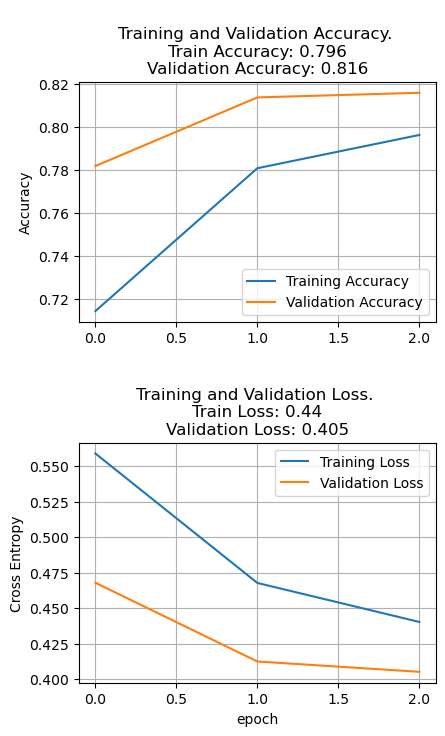

In [26]:
plot_history(history)

# VGG16

In [28]:
accuracy_score = inception_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 208s 5s/step - loss: 0.3403 - accuracy: 0.8487
[0.34029123187065125, 0.8487499952316284]
Accuracy: 84.87%
Loss: 0.340


**VGG 16**

In [29]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

58889256/58889256 [==============================] - 0s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/3
196/196 [==============================] - 548s 3s/step - loss: 0.6237 - accuracy: 0.6476 - val_loss: 0.5453 - val_accuracy: 0.7243
Epoch 2/3
196/196 [==============================] - 471s 2s/step - loss: 0.5352 - accuracy: 0.7314 - val_loss: 0.5019 - val_accuracy: 0.7545
Epoch 3/3
196/196 [==============================] - 456s 2s/step - loss: 0.5038 - accuracy: 0.7549 - val_loss: 0.4807 - val_accuracy: 0.7685


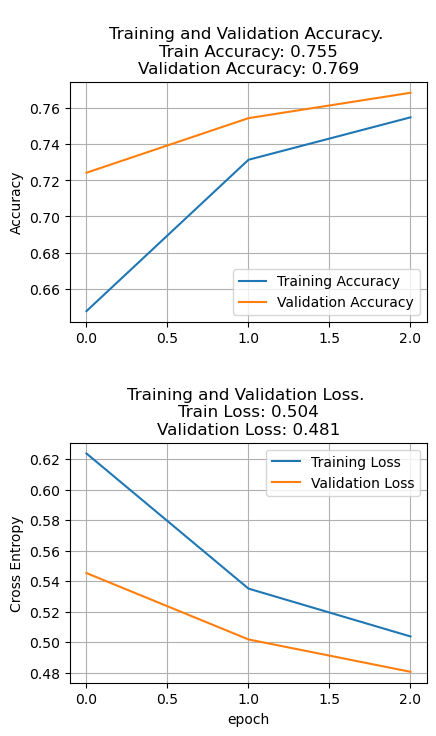

In [30]:
plot_history(history)

In [31]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(vgg16_base_model.layers)
print("VGG16 base layers = ", nr_base_layers)    

history = fit_model(vgg16_model, vgg16_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

VGG16 base layers =  19
Unfreezing number of layers in base model =  4
Epoch 1/7
196/196 [==============================] - 482s 2s/step - loss: 0.4183 - accuracy: 0.8095 - val_loss: 0.3245 - val_accuracy: 0.8613
Epoch 2/7
196/196 [==============================] - 454s 2s/step - loss: 0.2927 - accuracy: 0.8787 - val_loss: 0.2460 - val_accuracy: 0.8996
Epoch 3/7
196/196 [==============================] - 464s 2s/step - loss: 0.2334 - accuracy: 0.9063 - val_loss: 0.2238 - val_accuracy: 0.9068
Epoch 4/7
196/196 [==============================] - 486s 2s/step - loss: 0.1817 - accuracy: 0.9301 - val_loss: 0.1766 - val_accuracy: 0.9290
Epoch 5/7
196/196 [==============================] - 477s 2s/step - loss: 0.1537 - accuracy: 0.9418 - val_loss: 0.1860 - val_accuracy: 0.9254
Epoch 6/7
196/196 [==============================] - 462s 2s/step - loss: 0.1283 - accuracy: 0.9534 - val_loss: 0.1480 - val_accuracy: 0.9413
Epoch 7/7
196/196 [==============================] - 461s 2s/step - loss: 0.1

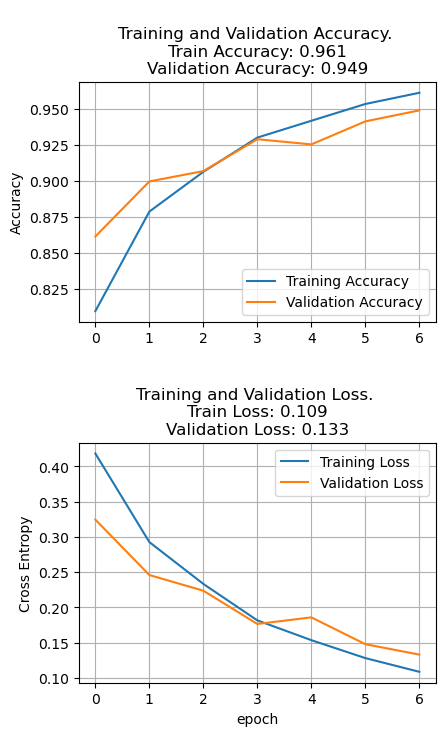

In [32]:
plot_history(history)

In [33]:
accuracy_score = vgg16_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 91s 2s/step - loss: 0.1326 - accuracy: 0.9481
[0.13263162970542908, 0.9480500221252441]
Accuracy: 94.81%
Loss: 0.133


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

In [ ]:
fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(test_generator.classes, vgg16_test_preds[:,1])
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

In [ ]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, vgg16_test_preds)

In [ ]:
last_conv_layer_name = "block5_conv3"

heatmaps =[]

for img in x:
    heatmap = make_gradcam_heatmap(img, vgg16_model, last_conv_layer_name)
    heatmaps.append(heatmap)
    
plot_images(heatmaps, y, vgg16_test_preds)

# Xception

In [ ]:
# load the xception architecture with imagenet weights as base
xception_base_model = tf.keras.applications.xception.Xception(
                                 include_top = False,
                                 weights = 'imagenet',
                                 input_shape = (image_height, image_width, 3)
                                 )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
xception_model = create_model(xception_base_model)
#xception_model.summary()
history = fit_model(xception_model, xception_base_model, epochs = TRAINING_EPOCHS)

In [ ]:
plot_history(history)

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(xception_base_model.layers)
print("xception base layers = ", nr_base_layers)    

history = fit_model(xception_model, xception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

In [ ]:
plot_history(history)

In [ ]:
accuracy_score = xception_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

xception_test_preds = xception_model.predict(test_generator)
xception_test_pred_classes = np.argmax(xception_test_preds, axis = 1)

In [ ]:
fpr_xception, tpr_xception, thresholds_xception = roc_curve(test_generator.classes, xception_test_preds[:,1])
auc_xception = auc(fpr_xception, tpr_xception)

In [ ]:
test_generator.reset()
x, y = next(test_generator)
plot_images(x, y, xception_test_preds)

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"

heatmaps = []

for img in x:
    heatmap = make_gradcam_heatmap(img, xception_model, last_conv_layer_name)
    heatmaps.append(heatmap)
    
plot_images(heatmaps, y, xception_test_preds)

# Confusion Matrix

In [ ]:
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = test_generator.classes

plot_heatmap(true_classes, inception_test_pred_classes, class_names, ax1, title = "Inception")    
plot_heatmap(true_classes, vgg16_test_pred_classes, class_names, ax2, title = "VGG16")    
plot_heatmap(true_classes, xception_test_pred_classes, class_names, ax3, title = "Xception")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# Ensemble

In [ ]:
ensemble_preds = np.add(np.add(inception_test_preds, vgg16_test_preds), xception_test_preds)/3.0

In [ ]:
ensemble_test_pred_classes = np.argmax(ensemble_preds, axis = 1)

In [ ]:
test_generator.reset()
x, y = next(test_generator)
plot_images(x, y, ensemble_preds)

In [ ]:
# Display confusion matrix
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 8))

true_classes = test_generator.classes

plot_heatmap(true_classes, ensemble_test_pred_classes, class_names, ax1, title = "Ensemble")        

fig.suptitle("Confusion Matrix Model", fontsize = 15)
fig.tight_layout()
plt.show()

In [ ]:
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(test_generator.classes, ensemble_preds[:,1])
auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inception, tpr_inception, label='ResNet (area = {:.3f})'.format(auc_inception))
plt.plot(fpr_vgg16, tpr_vgg16, label='VGG16 (area = {:.3f})'.format(auc_vgg16))
plt.plot(fpr_xception, tpr_xception, label='Xception (area = {:.3f})'.format(auc_xception))
plt.plot(fpr_ensemble, tpr_ensemble, label='Ensemble (area = {:.3f})'.format(auc_ensemble))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [34]:
import pickle
with open('model2.pkl','wb') as model_file:
    pickle.dump(vgg16_model,model_file)